In [93]:
from torchvision.datasets import CIFAR10
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

from d2l import torch as d2l

import random


In [94]:
train_set=CIFAR10('./data',train=True,download=True)
test_set=CIFAR10('./data',train=False,download=True)

Files already downloaded and verified
Files already downloaded and verified


In [95]:
batch_size=100
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size = batch_size,shuffle= True)
test_loader = torch.utils.data.DataLoader(dataset = test_set,batch_size = batch_size,shuffle= True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


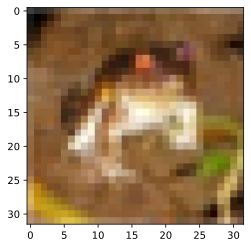

frog


In [96]:
digit = train_loader.dataset.data[0]
plt.imshow(digit,cmap=plt.cm.binary)
plt.show()
print(classes[train_loader.dataset.targets[0]])

In [97]:
train_data =  train_loader.dataset.data
train_labels = train_loader.dataset.targets
test_data =  test_loader.dataset.data
test_labels = test_loader.dataset.targets

print(train_data.shape,len(train_labels))

(50000, 32, 32, 3) 50000


In [98]:
train_data= np.array([ np.transpose(data,(2,0,1)) for data in train_data])
test_data= np.array([ np.transpose(data,(2,0,1)) for data in test_data])
print(train_data.shape)

(50000, 3, 32, 32)


In [99]:
transform_np_to_tensor = lambda x:torch.Tensor(x).to(torch.float32)

def data_iter(batch_size, dataset, labels):
    num_examples = len(dataset)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    for i in range(0, num_examples, batch_size):
        yield  map(transform_np_to_tensor,(dataset[i:i + batch_size], labels[i:i + batch_size]))


for X, y in data_iter(10, train_data, train_labels):
    print(X.shape, '\n', y.shape)
    break

torch.Size([10, 3, 32, 32]) 
 torch.Size([10])


In [100]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [101]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


In [102]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [103]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [104]:
def evaluate_accuracy_gpu(net, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter(batch_size,test_data,test_labels):
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [105]:
#@save
def train(net, num_epochs, lr, device):
    """Train a model with a GPU."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), 500 
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(data_iter(batch_size,train_data,train_labels)):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
           # X, y = X.to(torch.float), y.to(torch.float)
            y_hat = net(X)
            l = loss(y_hat, y.long())
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.766, train acc 0.732, test acc 0.625
1334.9 examples/sec on cuda:0


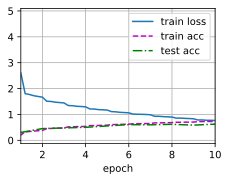

In [106]:
lr, num_epochs,batch_size = 0.9, 10,100
train(net, num_epochs, lr, d2l.try_gpu())